**Работа с MNIST-подобными данными**

# Импорт данных

In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными


from sklearn.preprocessing import StandardScaler
import sklearn.datasets as ds

from sklearn import preprocessing as prep

from sklearn.metrics import silhouette_samples # функция scikit-learn для оценки Коэффициента Силлуэта

import seaborn as sns# библиотека Seaborn для визуализации данных из Pandas
from sklearn.datasets import fetch_openml # функция библиотеки scikit-learn для загрузки данных с сайта OpenML
import matplotlib # библиотека Matplotlib для визуализации
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
# по разному импортируем потому что в модуле pyplot много рисования (и удобней сократить при применении),
# но нам понадобится ещё кое-что из matplotlib

In [ ]:
plt.style.use('dark_background')

# Классы, которые пригодятся нам в работе

## Метод главных компонент

In [ ]:
class PCA():
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None

    #--------------------------------
    def fit(self, X):
        # обучение - в этом случае сводится к нахождению собственных значений и собственных векторов

        self.mean = np.mean(X, axis=0) # оценка среднего для каждого признака

        # Считаем матрицу ковариации, используя функцию библиотеки Numpy
        cov_matrix = np.cov(X - self.mean, rowvar = False) # не забываем вычитать среднее


        # считаем собственные значания и собственные вектора матрицы ковариации
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix) # для этого тоже есть функция Numpy


        idx = eigenvalues.argsort()[::-1] #Сортируем по возрастанию собственных значений

        # Берём первые n собственных векторов
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx] # отсортированные собственные значения

        return self

    #--------------------------------
    def transform(self, X):
        # преобразование признаков в пространство главных компонент
        X = X - self.mean #вычитаем среднее
        return np.dot(X, self.components) #находим проекции признаков на собственные вектора (через скалярное произведение)
        #это и будут главные компоненты
    #--------------------------------
    def fit_transform(self, X):
        # 2 в 1: обучаем и преобразуем
        return self.fit(X).transform(X)
    #--------------------------------
    def inverse_transform(self, X_new):
        # обратное преобразование
        # Главные компоненты скалярно домножаем на собственные вектора
        return np.dot(X_new, self.components.T) + self.mean # не забываем обратно добавить среднее
    #--------------------------------
    def score(self, X):
        # оцека "качества" восстановления, через коэффициент детерминации
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    #--------------------------------
    def plot_eigvalues(self, figsize=(15,7)):
        # метод для отрисовки собственных значений (объясненной дисперсии)
        plt.figure(figsize=figsize)
        # отдельно мелкими точками визуализируем все собственные значения
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)
        # крупными маркерами - выбранное нами количество гласвных компонент
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('Собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(fontsize = 25); plt.yticks(fontsize = 25);
        plt.tight_layout();

In [ ]:
def plot_scatter(x,y,title_x = '', title_y = ''):
    fig = plt.figure(figsize=(10,7))
    plt.grid()

    plt.scatter(x,y,
                alpha = 0.5, s = 196,
                c = 'orange', edgecolor = 'r')
    plt.xlabel(title_x,fontsize=35)
    plt.ylabel(title_y,fontsize=35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.tight_layout();

## Визуализация кластера

In [ ]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    fig = plt.figure(figsize=(11,10)) # Создаем полотно
    # Визуализируем наши признаки
    plt.scatter(X[:, 0], X[:, 1],
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.3)
    # Визуализируем текущие центры кластеров. Как точки, но побольше
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'w')

    if old_centroids is not None: # если хотим визуализировать предыдущие центры кластеров
        # их отрисуем поменьше, чем текущие центры, но больше чем "рядовые точки"
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'w')

    plt.xticks([])
    plt.yticks([])

## Класс K-Means

In [ ]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state
    #-------------------------------------
    def distance(self,X1, X2):
        # оценка расстояния
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)
        return dist
    #-------------------------------------
    def init_centroids(self, X):
        # инициализация первых центров кластеров
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        # оценка пренадлежности точек к кластеру по расстоянию
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1)
    #-------------------------------------
    def transform(self,X):
        # получение предсказаний
        return self.predict(X)
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        # оценка относительного изменения центров кластеров
        return (
                self.distance(self.centroids,old_centroids)/
                self.distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):
        # обучение - несколько итераций алгоритма к-Средних
        if self.centroids is None: # если центры кластеров не заданы - задаем
            self.centroids = self.init_centroids(X)

        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)

            cluster_label = self.predict(X)

            for k in range(self.n_clusters):

                c_idxs = np.flatnonzero(cluster_label==k)

                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self
    #-------------------------------------
    def fit_transform(self, X):
        # и обучаем и сразу выдаем метки кластеров
        return self.fit(X).predict(X)


# Набор Kuzushiji-MNIST

In [ ]:
X, y  = fetch_openml('Kuzushiji-MNIST', version=1, return_X_y=True, as_frame = True)
X = X / 255.
X_ = X.values

In [ ]:
X

,pixel-0000,pixel-0001,pixel-0002,pixel-0003,pixel-0004,pixel-0005,pixel-0006,pixel-0007,pixel-0008,pixel-0009,...,pixel-0774,pixel-0775,pixel-0776,pixel-0777,pixel-0778,pixel-0779,pixel-0780,pixel-0781,pixel-0782,pixel-0783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.478431,1.000000,0.352941,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125490,0.643137,...,1.000000,0.250980,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.607843,0.768627,...,0.329412,0.231373,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


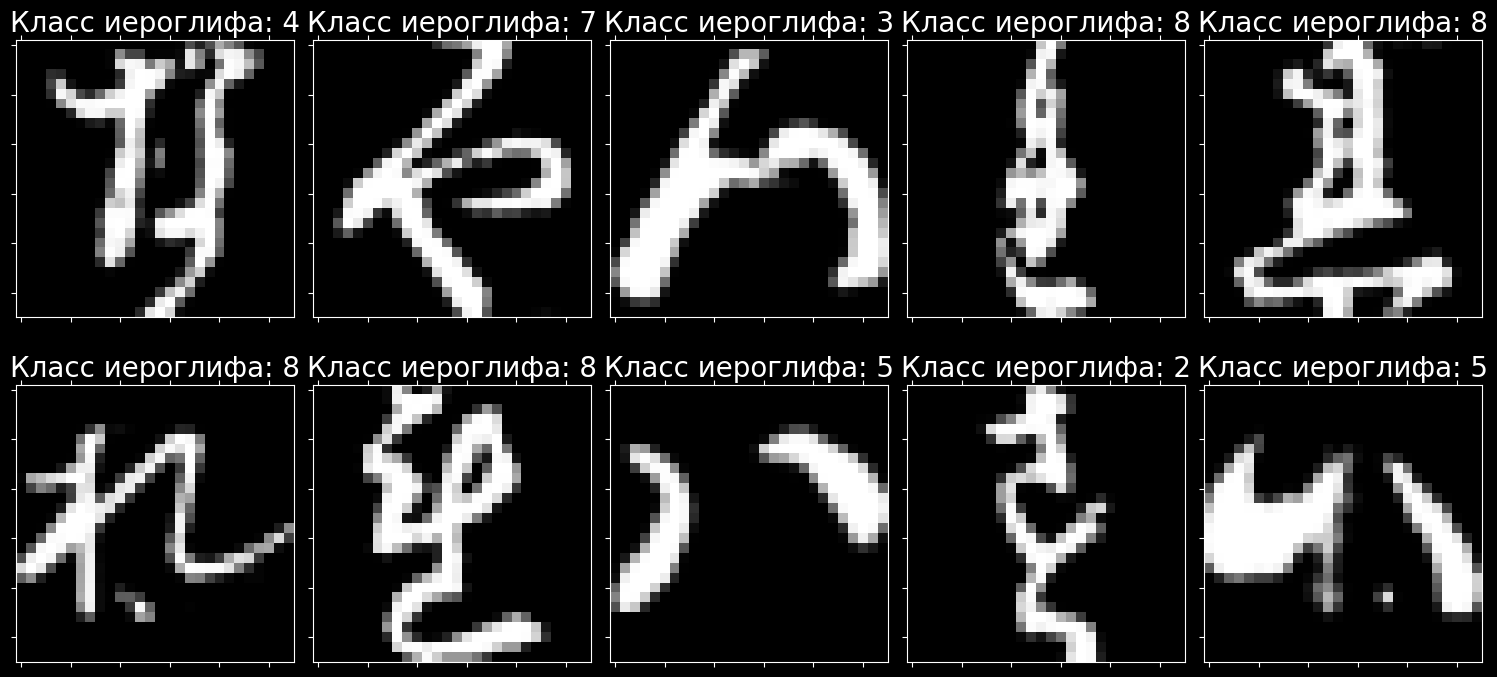

In [ ]:
n =  15258

fig = plt.figure( figsize=(15,8) )

for i in range(0,10):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_title(f"Класс иероглифа: {y[i + n]}", size=20)
    ax.matshow(1-X.loc[i+n,'pixel-0000':'pixel-0783'].values.reshape((28,28)).astype(float),
                cmap='Greys')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.tight_layout()

Вот все 10 классов иероглифов:

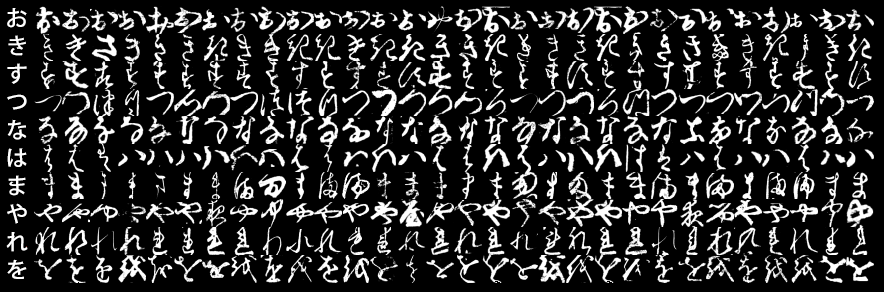

# Применяем Метод Главных Компонент к данным MNIST

В прошлой домашке с помощью кумулятивной дисперсии выяснилось, что для снижения размерности без большой потери информации должно быть достаточно примерно 200 компонент

In [ ]:
pca = PCA(n_components = 200)
pca.fit(X_)
pca.score(X_)

0.9410817235682846

In [ ]:
pca_result_mnist = pca.transform(X_)

In [ ]:
pca_inverse = pca.inverse_transform(pca_result_mnist)

In [ ]:
pca_inverse.shape

(70000, 784)

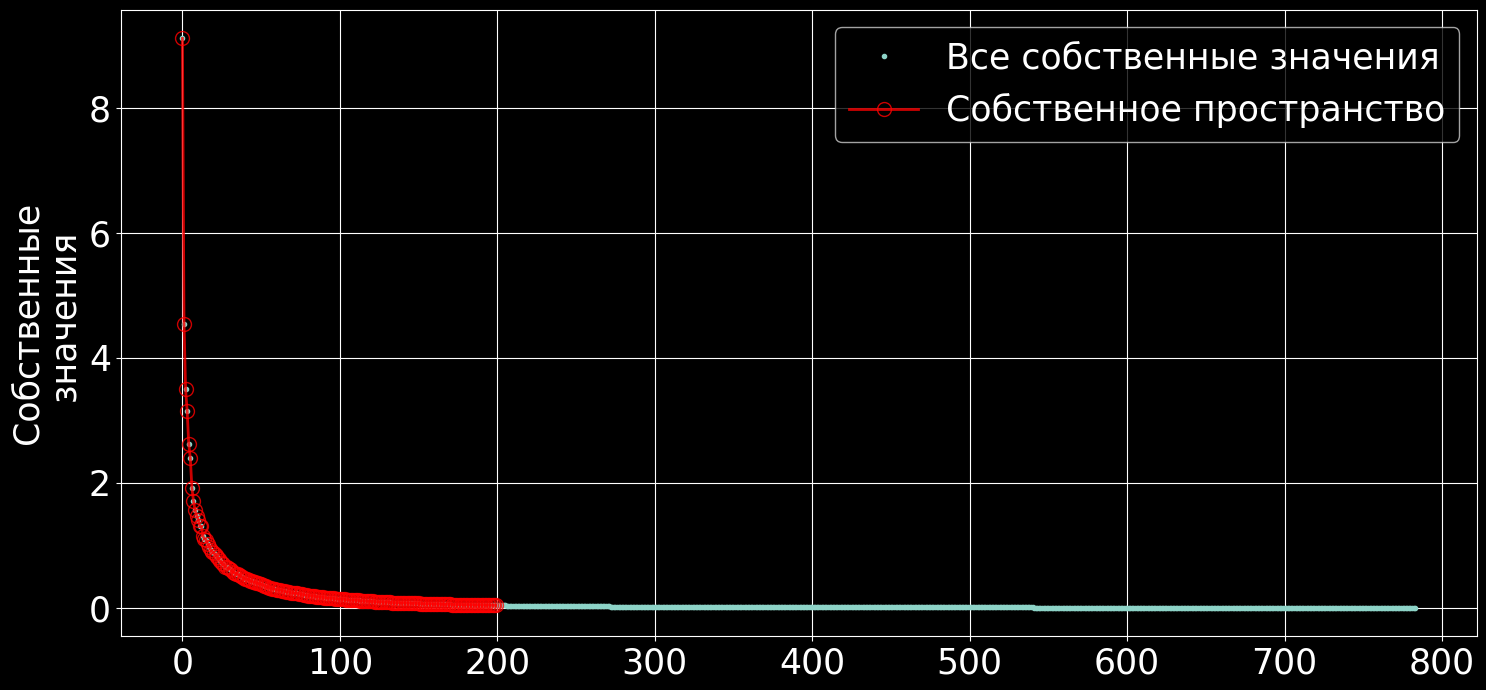

In [ ]:
pca.plot_eigvalues();

Сохраним результаты Метода главных компонент, чтобы использовать их в качестве входных данных для K-средних

In [ ]:
X_pca = pca.fit_transform(X_)

# Оценим оптимальное число кластеров методом Локтя

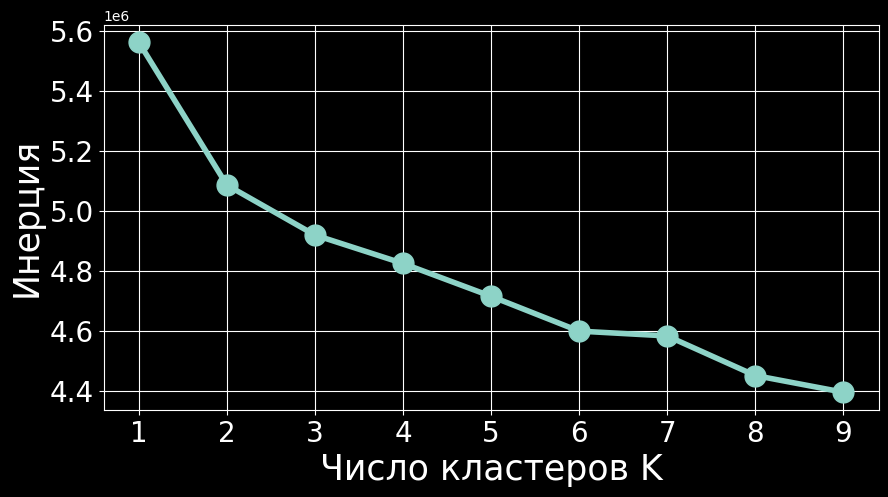

In [ ]:
sse = [] # здесь будем хранить инерции для конкретных к
list_k = list(range(1, 10))
for k in list_k: # тестируем различные к в диапазоне от 1 до 5
    km = KMeans(n_clusters=k)# создаем объект кластеризации с заданным к
    km.fit(X_pca) # обучаем
    sse.append(km.inertia) # фиксируем текущую инерцию

# визуализируем метод локтя. ниже используется много раз встречающаяся визуализация
plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

Пока непонятно. Вроде бы больше всего подходит 2 кластера.

# Применим кластеризацию K-Means

Мы остановились на итерации:: 8


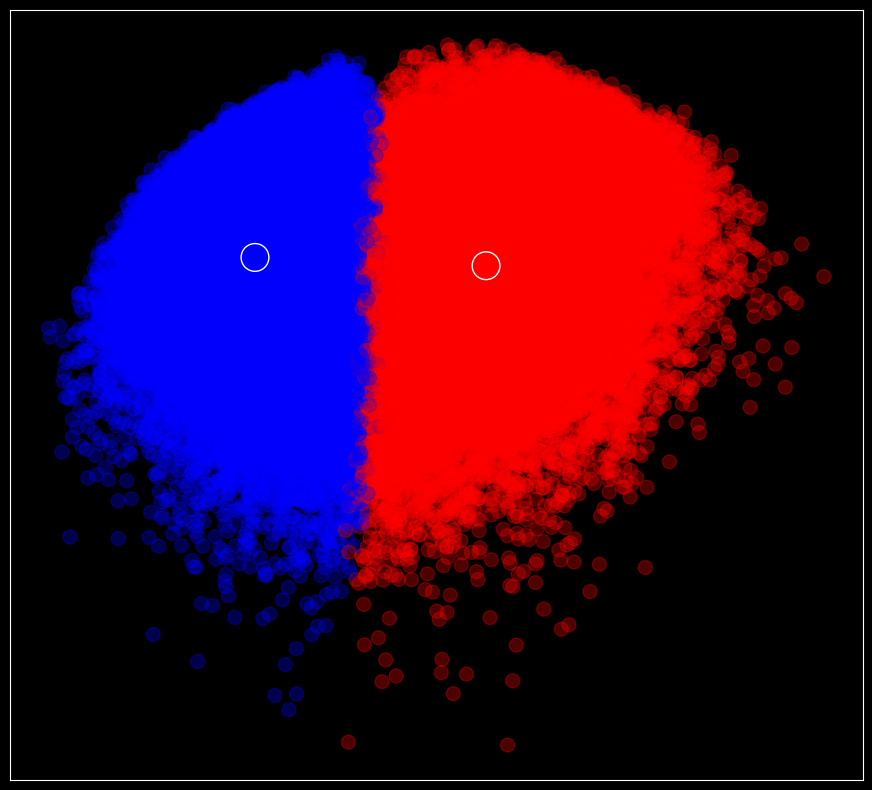

In [ ]:
kmeans   = KMeans(n_clusters=2,max_iter=100, tol=0.01, random_state= 42) # создаем объект
c_labels = kmeans.fit_transform(X_pca) # обучаем и сразу складываем метки кластеров

print('Мы остановились на итерации::',kmeans.iters)

# визуализируем
plot_cluster(X_pca,kmeans.centroids,
             c_labels, np.unique(c_labels),)

Вроде все нормально, но что то не то, данные как будто бы явлются большой кучкой, сложно определить правильное число кластеров. Попробуем сделать три кластера

Мы остановились на итерации:: 42


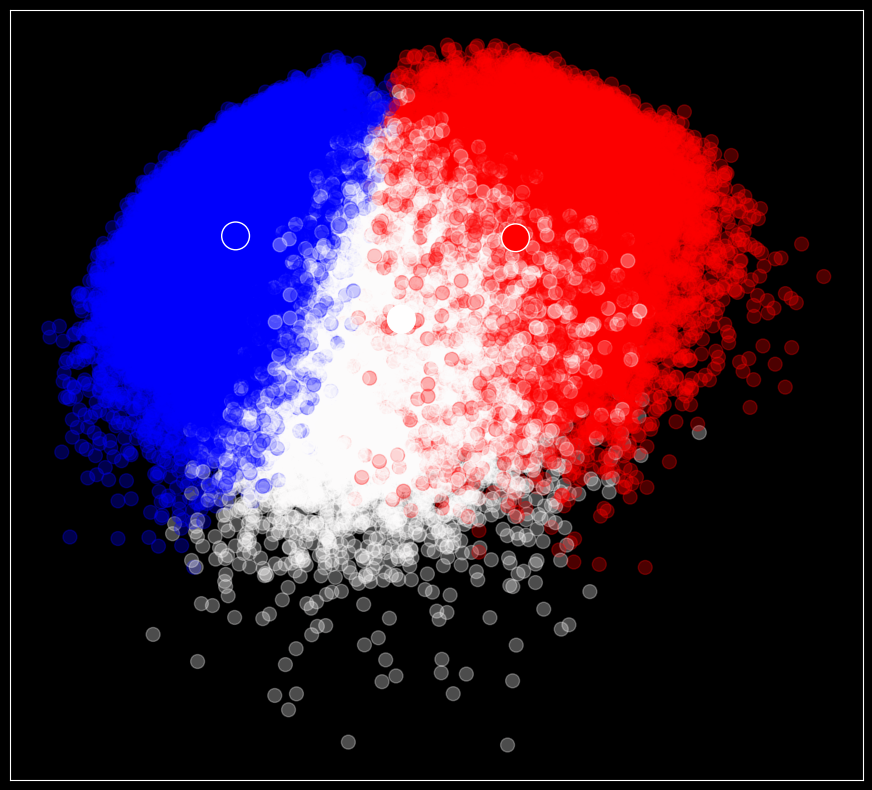

In [ ]:
kmeans   = KMeans(n_clusters=3,max_iter=100, tol=0.01, random_state= 42) # создаем объект
c_labels = kmeans.fit_transform(X_pca) # обучаем и сразу складываем метки кластеров

print('Мы остановились на итерации::',kmeans.iters)

# визуализируем
plot_cluster(X_pca,kmeans.centroids,
             c_labels, np.unique(c_labels),)

Сомнительно, ну окей. Зато получился флаг Франции

# Оцените связь кластеров с метками классов на изображениях

In [ ]:
c_labels = kmeans.fit_transform(X_pca)
pd.crosstab(y,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2
Метки,,,
0,30,1488,5482
1,5254,1727,19
2,5452,1505,43
3,102,2256,4642
4,2478,4143,379
5,2368,357,4275
6,5692,1164,144
7,824,1247,4929
8,3586,2658,756


0 кластер связан с метками: 1, 2 и 6

1 кластер связан с метками: 4 и 9

2 класетр связан с метками: 0, 3, 5 и 7

Мне кажется, отдельные классы в кластеры не разделяются особо (хотя если притянуть за уши то окей)

# Выводы

Определение количества кластеров методом локтя было неочевидным. На глаз кажется что это вообще один большой кластер. Вроде бы, связь между классами и кластерами прослеживается, но не то чтобы вау.